### Modeling 시작

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Dataset 준비
사전에 미리 전처리 해둔 데이터셋을 기반으로 학습한다.

In [2]:
dataset = pd.read_csv(r"D:\Intel\NLP_Project\modeling\new_df.csv")[['title', 'label']]

In [3]:
dataset['label'].value_counts() # 라벨값이 어느정도 균등하게 분포되어 있는 모습

label
1    119070
0    118169
Name: count, dtype: int64

In [4]:
dataset.head()

,title,label
0,사는이야기발달장애 아들과 매주 떠나는 여행을 시작했습니다,0
1,연하장 만들고 있습니다,0
2,취목을하다 제의 인생을찾은 지금,0
3,혹시 죄탁 가운데 불판가스 넣고싶은데,0
4,사는이야기눈쌓인게 이쁘네요,0


### Dataset 분할

In [5]:
train_data, test_data = train_test_split(dataset, test_size=0.25, random_state=0) # 7.5 : 2.5 비율로 분할한다.

In [6]:
print(train_data.shape)

(177929, 2)


In [7]:
print(test_data.shape)

(59310, 2)


In [9]:
train_data['label'].value_counts()

label
1    89356
0    88573
Name: count, dtype: int64

In [10]:
test_data['label'].value_counts()

label
1    29714
0    29596
Name: count, dtype: int64

### Stop words 정의

In [11]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# stopwords = """아 휴 아이구 아이쿠 아이고 어 나 우리 저희 따라 의해 을 를 에 의 가 으로 로 에게 뿐이다 의거하여 근거하여 
# 입각하여 기준으로 예하면 예를 들면 예를 들자면 저 소인 소생 저희 지말고 하지마 하지마라 다른 물론 또한 
# 그리고 비길수 없다 해서는 안된다 뿐만 아니라 만이 아니다 만은 아니다 막론하고 관계없이 그치지 않다 그러나 
# 그런데 하지만 든간에 논하지 않다 따지지 않다 설사 비록 더라도 아니면 만 못하다 하는 편이 낫다 불문하고 향하여 
# 향해서 향하다 쪽으로 틈타 이용하여 타다 오르다 제외하고 이 외에 이 밖에 하여야 비로소 한다면 몰라도 외에도 이곳 
# 여기 부터 기점으로 따라서 할 생각이다 하려고하다 이리하여 그리하여 그렇게 함으로써 하지만 일때 할때 앞에서 중에서 
# 보는데서 으로써 로써 까지 해야한다 일것이다 반드시 할줄알다 할수있다 할수있어 임에 틀림없다 한다면 등 등등 제 겨우 
# 단지 다만 할뿐 딩동 댕그 대해서 대하여 대하면 훨씬 얼마나 얼마만큼 얼마큼 남짓 여 얼마간 약간 다소 좀 조금 다수 
# 몇 얼마 지만 하물며 또한 그러나 그렇지만 하지만 이외에도 대해 말하자면 뿐이다 다음에 반대로 반대로 말하자면 이와 
# 반대로 바꾸어서 말하면 바꾸어서 한다면 만약 그렇지않으면 까악 툭 딱 삐걱거리다 보드득 비걱거리다 꽈당 응당 해야한다 
# 에 가서 각 각각 여러분 각종 각자 제각기 하도록하다 와 과 그러므로 그래서 고로 한 까닭에 하기 때문에 거니와 이지만 대하여 
# 관하여 관한 과연 실로 아니나다를가 생각한대로 진짜로 한적이있다 하곤하였다 하 하하 허허 아하 거바 와 오 왜 어째서 무엇때문에 
# 어찌 하겠는가 무슨 어디 어느곳 더군다나 하물며 더욱이는 어느때 언제 야 이봐 어이 여보시오 흐흐 흥 휴 헉헉 헐떡헐떡 영차 여차 
# 어기여차 끙끙 아야 앗 아야 콸콸 졸졸 좍좍 뚝뚝 주룩주룩 솨 우르르 그래도 또 그리고 바꾸어말하면 바꾸어말하자면 혹은 혹시 답다 및 
# 그에 따르는 때가 되어 즉 지든지 설령 가령 하더라도 할지라도 일지라도 지든지 몇 거의 하마터면 인젠 이젠 된바에야 된이상 만큼 
# 어찌됏든 그위에 게다가 점에서 보아 비추어 보아 고려하면 하게될것이다 일것이다 비교적 좀 보다더 비하면 시키다 하게하다 할만하다 
# 의해서 연이서 이어서 잇따라 뒤따라 뒤이어 결국 의지하여 기대여 통하여 자마자 더욱더 불구하고 얼마든지 마음대로 주저하지 않고 곧 
# 즉시 바로 당장 하자마자 밖에 안된다 하면된다 그래 그렇지 요컨대 다시 말하자면 바꿔 말하면 즉 구체적으로 말하자면 시작하여 시초에 
# 이상 허 헉 허걱 바와같이 해도좋다 해도된다 게다가 더구나 하물며 와르르 팍 퍽 펄렁 동안 이래 하고있었다 이었다 에서 로부터 까지 예하면 
# 했어요 해요 함께 같이 더불어 마저 마저도 양자 모두 습니다 가까스로 하려고하다 즈음하여 다른 다른 방면으로 해봐요 습니까 했어요 말할것도 
# 없고 무릎쓰고 개의치않고 하는것만 못하다 하는것이 낫다 매 매번 들 모 어느것 어느 로써 갖고말하자면 어디 어느쪽 어느것 어느해 어느 년도 라 
# 해도 언젠가 어떤것 어느것 저기 저쪽 저것 그때 그럼 그러면 요만한걸 그래 그때 저것만큼 그저 이르기까지 할 줄 안다 할 힘이 있다 너 너희 당신 
# 어찌 설마 차라리 할지언정 할지라도 할망정 할지언정 구토하다 게우다 토하다 메쓰겁다 옆사람 퉤 쳇 의거하여 근거하여 의해 따라 힘입어 그 다음 
# 버금 두번째로 기타 첫번째로 나머지는 그중에서 견지에서 형식으로 쓰여 입장에서 위해서 단지 의해되다 하도록시키다 뿐만아니라 반대로 전후 전자 
# 앞의것 잠시 잠깐 하면서 그렇지만 다음에 그러한즉 그런즉 남들 아무거나 어찌하든지 같다 비슷하다 예컨대 이럴정도로 어떻게 만약 만일 위에서 
# 서술한바와같이 인 듯하다 하지 않는다면 만약에 무엇 무슨 어느 어떤 아래윗 조차 한데 그럼에도 불구하고 여전히 심지어 까지도 조차도 하지 않도록 
# 않기 위하여 때 시각 무렵 시간 동안 어때 어떠한 하여금 네 예 우선 누구 누가 알겠는가 아무도 줄은모른다 줄은 몰랏다 하는 김에 겸사겸사 하는바 
# 그런 까닭에 한 이유는 그러니 그러니까 때문에 그 너희 그들 너희들 타인 것 것들 너 위하여 공동으로 동시에 하기 위하여 어찌하여 무엇때문에 붕붕 
# 윙윙 나 우리 엉엉 휘익 윙윙 오호 아하 어쨋든 만 못하다 하기보다는 차라리 하는 편이 낫다 흐흐 놀라다 상대적으로 말하자면 마치 아니라면 쉿 그렇지 
# 않으면 그렇지 않다면 안 그러면 아니었다면 하든지 아니면 이라면 좋아 알았어 하는것도 그만이다 어쩔수 없다 하나 일 일반적으로 일단 한켠으로는 
# 오자마자 이렇게되면 이와같다면 전부 한마디 한항목 근거로 하기에 아울러 하지 않도록 않기 위해서 이르기까지 이 되다 로 인하여 까닭으로 
# 이유만으로 이로 인하여 그래서 이 때문에 그러므로 그런 까닭에 알 수 있다 결론을 낼 수 있다 으로 인하여 있다 어떤것 관계가 있다 관련이 있다 
# 연관되다 어떤것들 에 대해 이리하여 그리하여 여부 하기보다는 하느니 하면 할수록 운운 이러이러하다 하구나 하도다 다시말하면 다음으로 에 있다 
# 에 달려 있다 우리 우리들 오히려 하기는한데 어떻게 어떻해 어찌됏어 어때 어째서 본대로 자 이 이쪽 여기 이것 이번 이렇게말하자면 이런 이러한 
# 이와 같은 요만큼 요만한 것 얼마 안 되는 것 이만큼 이 정도의 이렇게 많은 것 이와 같다 이때 이렇구나 것과 같이 끼익 삐걱 따위 와 같은 사람들 
# 부류의 사람들 왜냐하면 중의하나 오직 오로지 에 한하다 하기만 하면 도착하다 까지 미치다 도달하다 정도에 이르다 할 지경이다 
# 결과에 이르다 관해서는 여러분 하고 있다 한 후 혼자 자기 자기집 자신 우에 종합한것과같이 총적으로 보면 총적으로 말하면 
# 총적으로 대로 하다 으로서 참 그만이다 할 따름이다 쿵 탕탕 쾅쾅 둥둥 봐 봐라 아이야 아니 와아 응 아이 참나 년 월 일 령 영 일 이 삼 사 오 육 
# 륙 칠 팔 구 이천육 이천칠 이천팔 이천구 하나 둘 셋 넷 다섯 여섯 일곱 여덟 아홉 령 영 이 있 하 것 들 그 되 수 이 보 않 없 나 사람 주 아니 등 
# 같 우리 때 년 가 한 지 대하 오 말 일 그렇 위하 때문 그것 두 말하 알 그러나 받 못하 일 그런 또 문제 더 사회 많 그리고 좋 크 따르 중 나오 가지 
# 씨 시키 만들 지금 생각하 그러 속 하나 집 살 모르 적 월 데 자신 안 어떤 내 내 경우 명 생각 시간 그녀 다시 이런 앞 보이 번 나 다른 어떻 여자 개 
# 전 들 사실 이렇 점 싶 말 정도 좀 원 잘 통하 놓""".replace("\n", "").split(" ")

In [12]:
train_data['title'] = train_data['title'].apply(lambda x : str(x))
test_data['title'] = test_data['title'].apply(lambda x : str(x))

### 토큰화

In [13]:
mecab = Mecab(r"C:\mecab\mecab-ko-dic") 

train_data['tokenized'] = train_data['title'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['title'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [14]:
unPopular = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
popular = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [15]:
unpopular_word_count = Counter(unPopular) # 시퀀스를 토큰화했을 때 가장 자주 등장하는 20개의 토큰을 확인한다.
print(unpopular_word_count.most_common(20))

AttributeError: 'function' object has no attribute 'most_common'

In [ ]:
popular_word_count = Counter(popular)
print(popular_word_count.most_common(20))

[('룸', 9085), ('하', 7769), ('월세', 6971), ('가능', 6681), ('분', 6641), ('원룸', 6498), ('전세', 5650), ('m', 5453), ('투', 5371), ('고', 4987), ('있', 4237), ('억', 4022), ('합니다', 3584), ('만', 3260), ('후기', 3079), ('시', 3047), ('채용', 2928), ('풀', 2918), ('나요', 2702), ('네요', 2597)]


인기 게시글제목의 평균 길이 : 8.140035364161331
비인기 게시글 제목의 평균 길이 : 7.0483894640578955


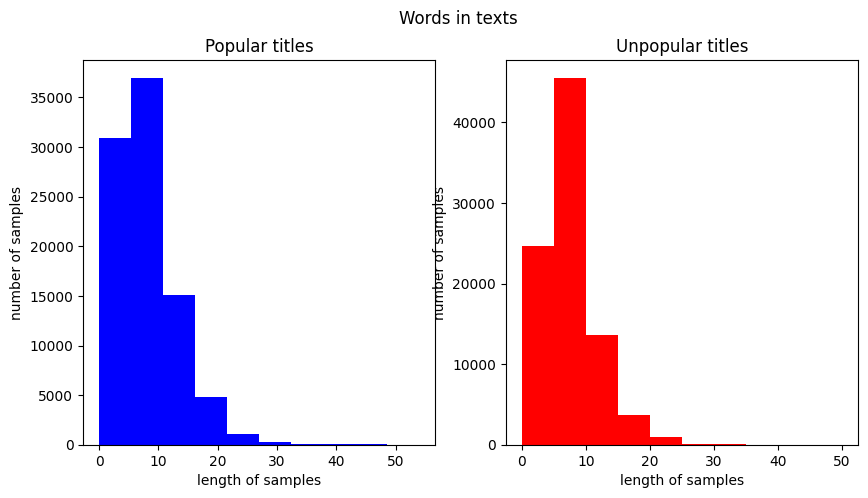

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='blue')
ax1.set_title('Popular titles')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('인기 게시글제목의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='red')
ax2.set_title('Unpopular titles')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('비인기 게시글 제목의 평균 길이 :', np.mean(text_len))
plt.show()

In [ ]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

### 정수형 인코딩

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 45753
등장 빈도가 1번 이하인 희귀 단어의 수: 18640
단어 집합에서 희귀 단어의 비율: 40.74049789084869
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.3790470666396382


단어의 등장 횟수가 1회인 단어들은 정수 인코딩 대상에서 제외시킨다. 단, zero padding 토큰과 oov 토큰을 고려하여 +2를 해준다.

In [ ]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 27115


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

제목의 최대 길이 : 54
제목의 평균 길이 : 7.596614379893103


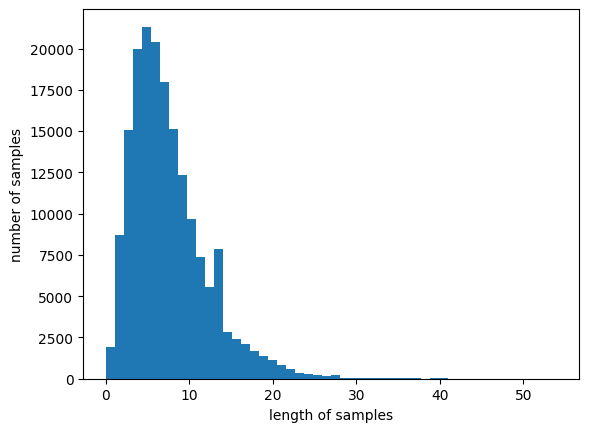

In [ ]:
print('제목의 최대 길이 :',max(len(review) for review in X_train))
print('제목의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
              count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

대부분의 제목들이 50글자 내로 들어오기에, max_len = 50으로 하여 padding한다. 

모델 성능 개선 시 시도해볼 것
- pre padding과 post padding 비교

In [ ]:
max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 99.99887595613981


In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

### Bi-Directional LSTM
일반적인 LSTM의 경우 forward 방향으로만 순환하며 Input, Forget, Output gate를 거친다. 이와 다르게 Bidirectional LSTM의 경우 forward와 backward로 순환하며 forward 방향으로만 흐를 때의 단점을 보완할 수 있다.

forward 방향으로만 흐를 때의 단점이란 아래와 같은 경우가 있다.

> 만약 "나는 _ 를 보고싶다" 라는 문장이 있다고 가정하자. _에 들어가는 단어를 예측하는 모델을 일반 LSTM과 Bidirectional LSTM모델 두 가지로 설계했다고 하고, 각 단어가 뱉을 수 있는 단어를 각각 w, g라고 하자. 그렇다면 P(w|를 보고싶다)의 확률과 P(g|를 보고싶다)의 조건부 확률을 비교하자면 후자가 월등하게 낮을 것이다. 한국어를 유창하게 하는 사람이라면 해당 문장을 보고 빈칸에 들어갈 수 있는 단어들을 간략하게 추린다. 하지만 forward 방향으로만 계산하는 알고리즘의 입장에서 w에는 무수히 많은 단어가 할당 될 것이다. 이것이 Bi-Directional LSTM이 가지는 장점이다.

### 모델 구조
모델의 구조는 아래와 같다.

<div align=center><img src="./image_for_markdown/bi-directional LSTM.png"></div>

LSTM과 동일하게 memory cell들을 거쳐 정방향으로 나열된 word vector와 함께 forward 방향으로 순환한 후, 끝에서 다시 역방향으로 나열된 word vector롸 함께 backward 방향으로 순환한다. 총 순환이 두 번 일어나는 것이다. 그렇게 두 번 순환된 결과를 `concat`하여 output layer에 전달한다.

### Data Flow
데이터 플로우는 아래와 같다.

<div align=center><img src="./image_for_markdown/di-directional LSTM data flow.png"></div>

### 아키텍쳐 구조에 대한 함정
normal한 LSTM을 사용할때와 마찬가지로, Multi Layer로 구성한다고 해서 반드시 성능이 좋아지기란 불가하다.

In [ ]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units, recurrent_activation="sigmoid", dropout=0.3, recurrent_dropout=0))) # Bidirectional LSTM을 사용
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=4)
mc = ModelCheckpoint('./model/with_237240_data_adam_optim.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
cl = CSVLogger("./history/237240_data_train_history.csv")

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.
# history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc, cl], batch_size=32, validation_split=0.2)

AttributeError: 'Sequential' object has no attribute 'input_layer'

In [ ]:
import pickle

with open('./model/168783_data_tokenizer.pickle', 'wb') as file:
     pickle.dump(tokenizer, file)

In [ ]:
loaded_model = load_model('./model/with_168783_data.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1319/1319 [==============================] - 9s 7ms/step - loss: 0.4373 - acc: 0.7851
테스트 정확도: 0.7851


In [ ]:
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-z ]','', new_sentence)
    new_sentence = mecab.morphs(new_sentence) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new, verbose=0)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 세상을 놀래킬 수 있겠군요 !".format(score * 100))
    else:
        print("{:.2f}% 확률로 인기를 얻기 어려울 것 같습니다. :(".format((1 - score) * 100))

In [ ]:
sentiment_predict('앱 중고상품 쟈딕앤볼테르 후드 집업')

98.77% 확률로 세상을 놀래킬 수 있겠군요 !


C:\Users\OWNER\AppData\Local\Temp\ipykernel_18596\3438716519.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new, verbose=0)) # 예측


### 1차 학습 완료 결과

마땅히 좋은 결과를 주는 것 같지 않다. 테스트를 진행한 방식은 아래와 같다.
- 네이버 카페 게시글 중, 수집하지 않았던 게시글의 제목을 model의 input으로 사용하여 정확도를 확인한다.

### 개선 방향

1. Feature Engineering
- 제목의 길이를 넣어서 제목의 길이와 조회수 간의 상관관계를 참조하며 학습할 수 있게 한다.
- 토큰화 및 정수형 인코딩 이후에 padding 시, post padding과 pre padding간의 성능을 비교한다.

2. Model Tuning
- recurrent dropout과 dropout을 설정하여 과적합을 방지한다.
    + recurrent dropout이란, 일반적인 nn에서 사용하는 dropout과는 다른 기법이다. 시점간에 주고받는 parameter들에 영향을 주는 것이 아닌, 현재 input에 영향을 받는 parameter들에만 dropout을 적용한다.

- merge_mode Tuning
    + merge_mode의 경우 forward방향의 lstm 셀이 출력하는 값과 backward방향의 lstm셀이 출력하는 두 개의 값을 병합하는 방식이다. sum, mul, concat, none, ave가 있다.

- 